In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Add, Dense, Dot, Dropout, Embedding, Input, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Load Dataset & Preprocessing

In [2]:
ori_df = pd.read_csv("./collab_mapped.csv")
ori_df["completion"] = ori_df["completion"].clip(0, 1)

<AxesSubplot:>

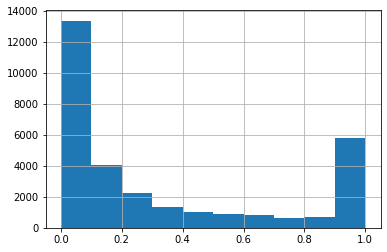

In [3]:
ori_df["completion"].hist()

### Sample data
Try to make the dataset into a long tail distribution
- undersample data (with completion == 1)

In [4]:
# completion < 1
df_less_than_1 = ori_df.loc[ori_df["completion"] < 1]

# undersample completion == 1 to (0.9 < completion < 1)
desired_num_completion_equal_1 = ori_df.loc[(ori_df['completion'] > 0.9) & (ori_df['completion'] < 1)].shape[0]
df_equal_1 = ori_df.loc[ori_df["completion"] == 1].sample(desired_num_completion_equal_1)

In [5]:
df = pd.concat([df_less_than_1, df_equal_1])

<AxesSubplot:>

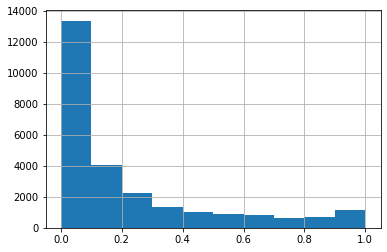

In [6]:
df["completion"].hist()

In [7]:
df.describe()

,user_index,item_index,completion
count,26285.000000,26285.000000,26285.000000
mean,234.375347,115.370554,0.211810
std,138.007537,72.731712,0.276236
min,0.000000,0.000000,0.000000
25%,111.000000,53.000000,0.033333
50%,234.000000,108.000000,0.068966
75%,355.000000,172.000000,0.310345
max,476.000000,267.000000,1.000000


In [8]:
uniq_user = df["user_index"].unique()
uniq_item = df["item_index"].unique()
assert len(uniq_user) == max(uniq_user) + 1
assert len(uniq_item) == max(uniq_item) + 1

# Config

In [9]:
MODEL_PATH = "./SavedModel/model.h5"
NUM_USER = len(df["user_index"].unique())
NUM_ITEM = len(df["item_index"].unique())
LATENT_DIM = 5

# Training

In [10]:
def gen_dataset(df, test_size=0.2):
    # Shuffle
    df = shuffle(df)

    # Split
    X, y = df[["user_index", "item_index"]].values, df[["completion"]].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    return X_train, X_test, y_train, y_test

In [11]:
def mf_model(n_user, n_item, latent_dim):
    """ Matrix factorization model
    """

    # Input
    user_input = Input(shape=[1])
    item_input = Input(shape=[1])
    
    # To Latent Vector
    user_latent = Embedding(n_user, latent_dim, embeddings_initializer="lecun_uniform",
                            embeddings_regularizer=l2(1e-5))(user_input)
    user_latent = Reshape((latent_dim,))(user_latent)
    user_latent = Dropout(0.1)(user_latent)
    
    item_latent = Embedding(n_item, latent_dim, embeddings_initializer="lecun_uniform",
                            embeddings_regularizer=l2(1e-5))(item_input)
    item_latent = Reshape((latent_dim,))(item_latent)
    item_latent = Dropout(0.1)(item_latent)

    # Add Bias
    user_bias = Embedding(n_user, 1, embeddings_regularizer=l2(1e-5))(user_input)
    user_bias = Reshape((1,))(user_bias)
    
    item_bias = Embedding(n_item, 1, embeddings_regularizer=l2(1e-5))(item_input)
    item_bias = Reshape((1,))(item_bias)
    
    # Dot
    r_hat = Dot(axes=-1)([user_latent, item_latent])
    r_hat = Add()([r_hat, user_bias, item_bias])    
    output = Dense(1, kernel_regularizer=l2(0.01))(r_hat)
    
    model = Model(inputs=[user_input, item_input], outputs=[output])

    return model

In [12]:
def train_model(df, latent_dim=20):
    # Load data
    X_train, X_test, y_train, y_test = gen_dataset(df)
    
    # Load matrix factorization model
    model = mf_model(NUM_USER, NUM_ITEM, latent_dim)
    model.compile(loss="mae", optimizer=optimizers.Adam(), metrics=["mae"])
    model.summary()
    
    # callbacks
    early_stop = EarlyStopping(monitor="val_mae", patience=3)
    checkpoint_filepath = MODEL_PATH
    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor="val_mae",
        verbose=1,
        save_best_only=True,
    )
    
    # Train Model
    history = model.fit([X_train[:, 0], X_train[:, 1]], [y_train],
                        validation_data=([X_test[:, 0], X_test[:, 1]], [y_test]),
                        batch_size=512,
                        epochs=50,
                        callbacks=[early_stop, model_checkpoint])
    
    # Save Model
    model.save(checkpoint_filepath)

    return model, history

In [13]:
model, history = train_model(df, latent_dim=LATENT_DIM)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 5)         2385        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 5)         1340        input_2[0][0]                    
_______________________________________________________________________________________

/home/user/Projects/garena/ENV/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


24/42 [================>.............] - ETA: 0s - loss: 0.2240 - mae: 0.2057
Epoch 00001: val_mae improved from inf to 0.18622, saving model to ./SavedModel/model.h5
42/42 [==============================] - 0s 6ms/step - loss: 0.2169 - mae: 0.1989 - val_loss: 0.2037 - val_mae: 0.1862
Epoch 2/50
25/42 [================>.............] - ETA: 0s - loss: 0.1937 - mae: 0.1764
Epoch 00002: val_mae improved from 0.18622 to 0.17501, saving model to ./SavedModel/model.h5
42/42 [==============================] - 0s 3ms/step - loss: 0.1911 - mae: 0.1740 - val_loss: 0.1917 - val_mae: 0.1750
Epoch 3/50
24/42 [================>.............] - ETA: 0s - loss: 0.1823 - mae: 0.1659
Epoch 00003: val_mae improved from 0.17501 to 0.17006, saving model to ./SavedModel/model.h5
42/42 [==============================] - 0s 3ms/step - loss: 0.1817 - mae: 0.1654 - val_loss: 0.1860 - val_mae: 0.1701
Epoch 4/50
38/42 [==========================>...] - ETA: 0s - loss: 0.1759 - mae: 0.1604
Epoch 00004: val_mae im

# Training Process

In [14]:
import matplotlib.pyplot as plt

def show_train_history(history, train_metric, test_metric):
    plt.plot(history.history[train_metric])
    plt.plot(history.history[test_metric])
    plt.title("Train History")
    plt.ylabel(train_metric)
    plt.xlabel("Epoch")
    plt.legend(["train", "test"], loc="upper right")
    plt.show()

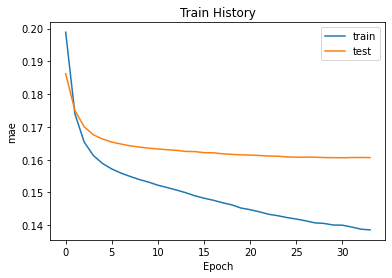

In [15]:
show_train_history(history, "mae", "val_mae")

# Predict simulated data

In [16]:
def predict(df):
    # Load model
    model_save_path = MODEL_PATH
    model = tf.keras.models.load_model(model_save_path)

    # Simulated predict data; 10% of whole data
    pred_df = df[["user_index", "item_index"]].sample(frac=0.1)
    pred = pred_df.values
    predition = model.predict([pred[:, 0], pred[:, 1]])

    # Construct Result
    pred_df["pred_completion"] = predition.clip(0, 1)
    return pred_df

In [17]:
pred_res = predict(df)
pred_res

,user_index,item_index,pred_completion
15562,210,28,0.000000
6053,237,91,0.000000
20275,423,190,0.054302
7665,250,75,0.000000
17476,393,130,0.032316
...,...,...,...
7694,118,243,0.341909
16075,259,108,0.227158
3979,160,220,0.175575
23028,43,28,0.047025


<AxesSubplot:>

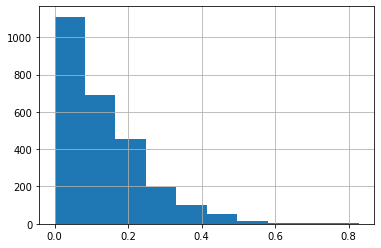

In [18]:
pred_res['pred_completion'].hist()